# First analysis of the results for the k technique (AUC-PR)

## Setup

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [3]:
# change css --jp-notebook-max-width
# from IPython.display import display, HTML
# display(HTML("<style>.container { jp-notebook-max-width:100% !important; }</style>"))

### Paths

In [4]:
csv_dir = '/home/sylli/Documents/MSAD-E/reports/aucpr_proba_04_2024'
save_fig_path = os.path.join(csv_dir, "figures")

### Variables

In [5]:
# Detectors
detector_names = [
	'AE', 
	'CNN', 
	'HBOS', 
	'IFOREST', 
	'IFOREST1', 
	'LOF', 
	'LSTM', 
	'MP', 
	'NORMA', 
	'OCSVM', 
	'PCA', 
	'POLY'
]

model_selectors = [
    "convnet128",
    "resnet1024",
    "sit512",
    "knn1024",
]

combine_methods = ['average', 'vote']

datasets = [
    'MGAB', 
    'GHL', 
    'MITDB', 
    'Genesis', 
    'OPPORTUNITY', 
    'SensorScope', 
    'KDD21', 
    'Occupancy', 
    'SVDB', 
    'IOPS', 
    'SMD', 
    'Daphnet',
    'ECG',
    'NAB',
    'YAHOO'
]

k_values = np.arange(1, 13)

## Helper functions

In [6]:
def load_results(csv_file):
    """Load results from a CSV file."""
    return pd.read_csv(csv_file, index_col=0)

def percentage_change(old_value, new_value):
    """
    Calculate the percentage change between two values.
    
    Parameters:
        old_value (float): The old value.
        new_value (float): The new value.
        
    Returns:
        float: The percentage change.
    """
    return ((new_value - old_value) / old_value) * 100

def highlight_max(s):
    is_max = s == s.max() 
    return ['font-weight: bold; background: lightgreen' if cell else '' for cell in is_max] 

## Load the data

### Read file names

In [7]:
result_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]
for i in np.random.randint(low=0, high=len(result_files), size=3):
    print(result_files[i])

GHL_sit512_vote_k9.csv
IOPS_sit512_vote_k9.csv
IOPS_knn1024_average_k6.csv


### Load all the data and create DataFrame

In [8]:
all_results = []
curr_experiment_env = set()

for file in result_files:
    parts = file.split('_')

    if len(parts) != 4:
        print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
    else:
        dataset = parts[0]
        model_selector = parts[1]
        combine_method = parts[-2]
        k = int(parts[-1].split('.')[0][1:])
        if (dataset not in datasets) or \
        (model_selector not in model_selectors) or \
        (combine_method not in combine_methods) or \
        (k not in k_values):
            print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
            break
        else:
            curr_df = pd.read_csv(os.path.join(csv_dir, file))
            curr_df.rename(columns={'Unnamed: 0': 'Time series'}, inplace=True)
            curr_df['Model Selector'] = model_selector
            curr_df['k'] = k
            curr_df['Combine Method'] = combine_method
            curr_df['Dataset'] = dataset
            all_results.append(curr_df)

            # Update curr existing datasets, MSs, etc.
            curr_experiment_env.add(dataset)
            curr_experiment_env.add(model_selector)
            curr_experiment_env.add(combine_method)
            curr_experiment_env.add(k)

df = pd.concat(all_results)
df.head(5)

,Time series,AUC-PR,weight_AE,weight_CNN,weight_HBOS,weight_IFOREST,weight_IFOREST1,weight_LOF,weight_LSTM,weight_MP,weight_NORMA,weight_OCSVM,weight_PCA,weight_POLY,Model Selector,k,Combine Method,Dataset
0,OPPORTUNITY/S4-ADL2.test.csv@120.out,0.627780,0.000000,0.0,0.371585,0.245902,0.262295,0.000000,0.0,0.120219,0.000000,0.0,0.000000,0.0,convnet128,4,vote,OPPORTUNITY
1,OPPORTUNITY/S4-ADL5.test.csv@54.out,0.440608,0.097222,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.060185,0.777778,0.0,0.064815,0.0,convnet128,4,vote,OPPORTUNITY
2,OPPORTUNITY/S1-ADL2.test.csv@103.out,0.910242,0.000000,0.0,0.253521,0.122066,0.000000,0.000000,0.0,0.248826,0.000000,0.0,0.375587,0.0,convnet128,4,vote,OPPORTUNITY
3,OPPORTUNITY/S2-ADL1.test.csv@124.out,0.379734,0.000000,0.0,0.291946,0.429530,0.000000,0.154362,0.0,0.000000,0.124161,0.0,0.000000,0.0,convnet128,4,vote,OPPORTUNITY
4,OPPORTUNITY/S4-ADL3.test.csv@53.out,0.088045,0.174419,0.0,0.000000,0.000000,0.000000,0.174419,0.0,0.000000,0.546512,0.0,0.104651,0.0,convnet128,4,vote,OPPORTUNITY


### Update the different environment/settings
This is done so that you can run the analysis with no problem even if you don't have everything required

In [9]:
datasets = [x for x in datasets if x in curr_experiment_env]
model_selectors = [x for x in model_selectors if x in curr_experiment_env]
combine_methods = [x for x in combine_methods if x in curr_experiment_env]
k_values = [x for x in k_values if x in curr_experiment_env]

## Analysis

### Comparing different values of k

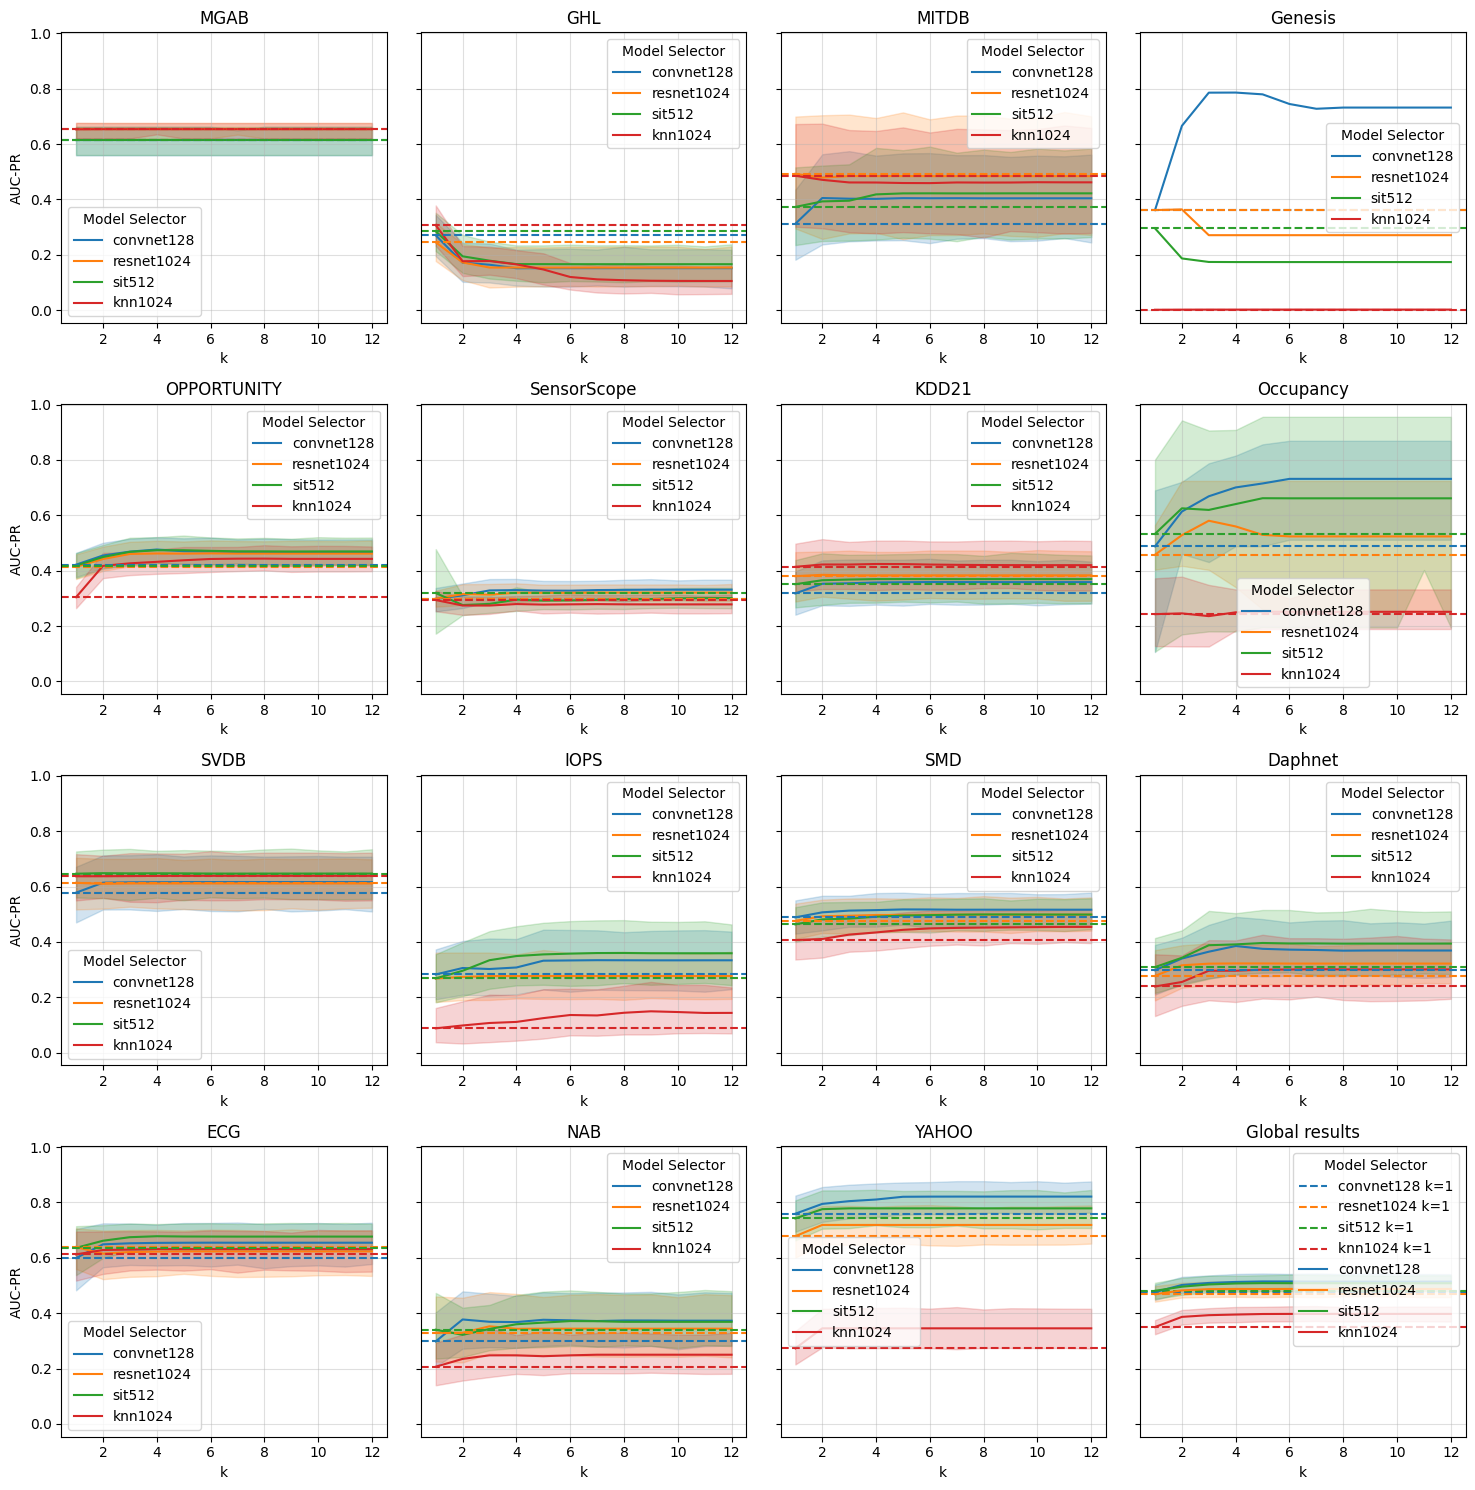

In [39]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)
combine_method = 'vote'

for i in range (0, len(datasets)):
    curr_data = df[(df["Dataset"] == datasets[i]) & (df["Combine Method"] == combine_method)]
    
    sns.lineplot(ax=axes[i//4, i % 4], data=curr_data, x="k", y="AUC-PR", hue="Model Selector", hue_order=model_selectors)

    # Compute average for k = 1
    for j, ms in enumerate(model_selectors):
        curr_avg_k1 = curr_data[(curr_data["Model Selector"] == ms) & (curr_data["k"] == 1)]['AUC-PR'].mean()
        axes[i//4, i % 4].axhline(y=curr_avg_k1, color=f'C{j}', linestyle='dashed', label=f'{ms} k=1')
    
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])

# Compute global plot
curr_data = df[(df["Combine Method"] == combine_method)]

# Compute average for k = 1
for j, ms in enumerate(model_selectors):
    curr_avg_k1 = curr_data[(curr_data["Model Selector"] == ms) & (curr_data["k"] == 1)]['AUC-PR'].mean()
    axes[3, 3].axhline(y=curr_avg_k1, color=f'C{j}', linestyle='dashed', label=f'{ms} k=1')
    
sns.lineplot(ax=axes[3, 3], data=curr_data, x="k", y="AUC-PR", hue="Model Selector", hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")

plt.tight_layout()
plt.show()

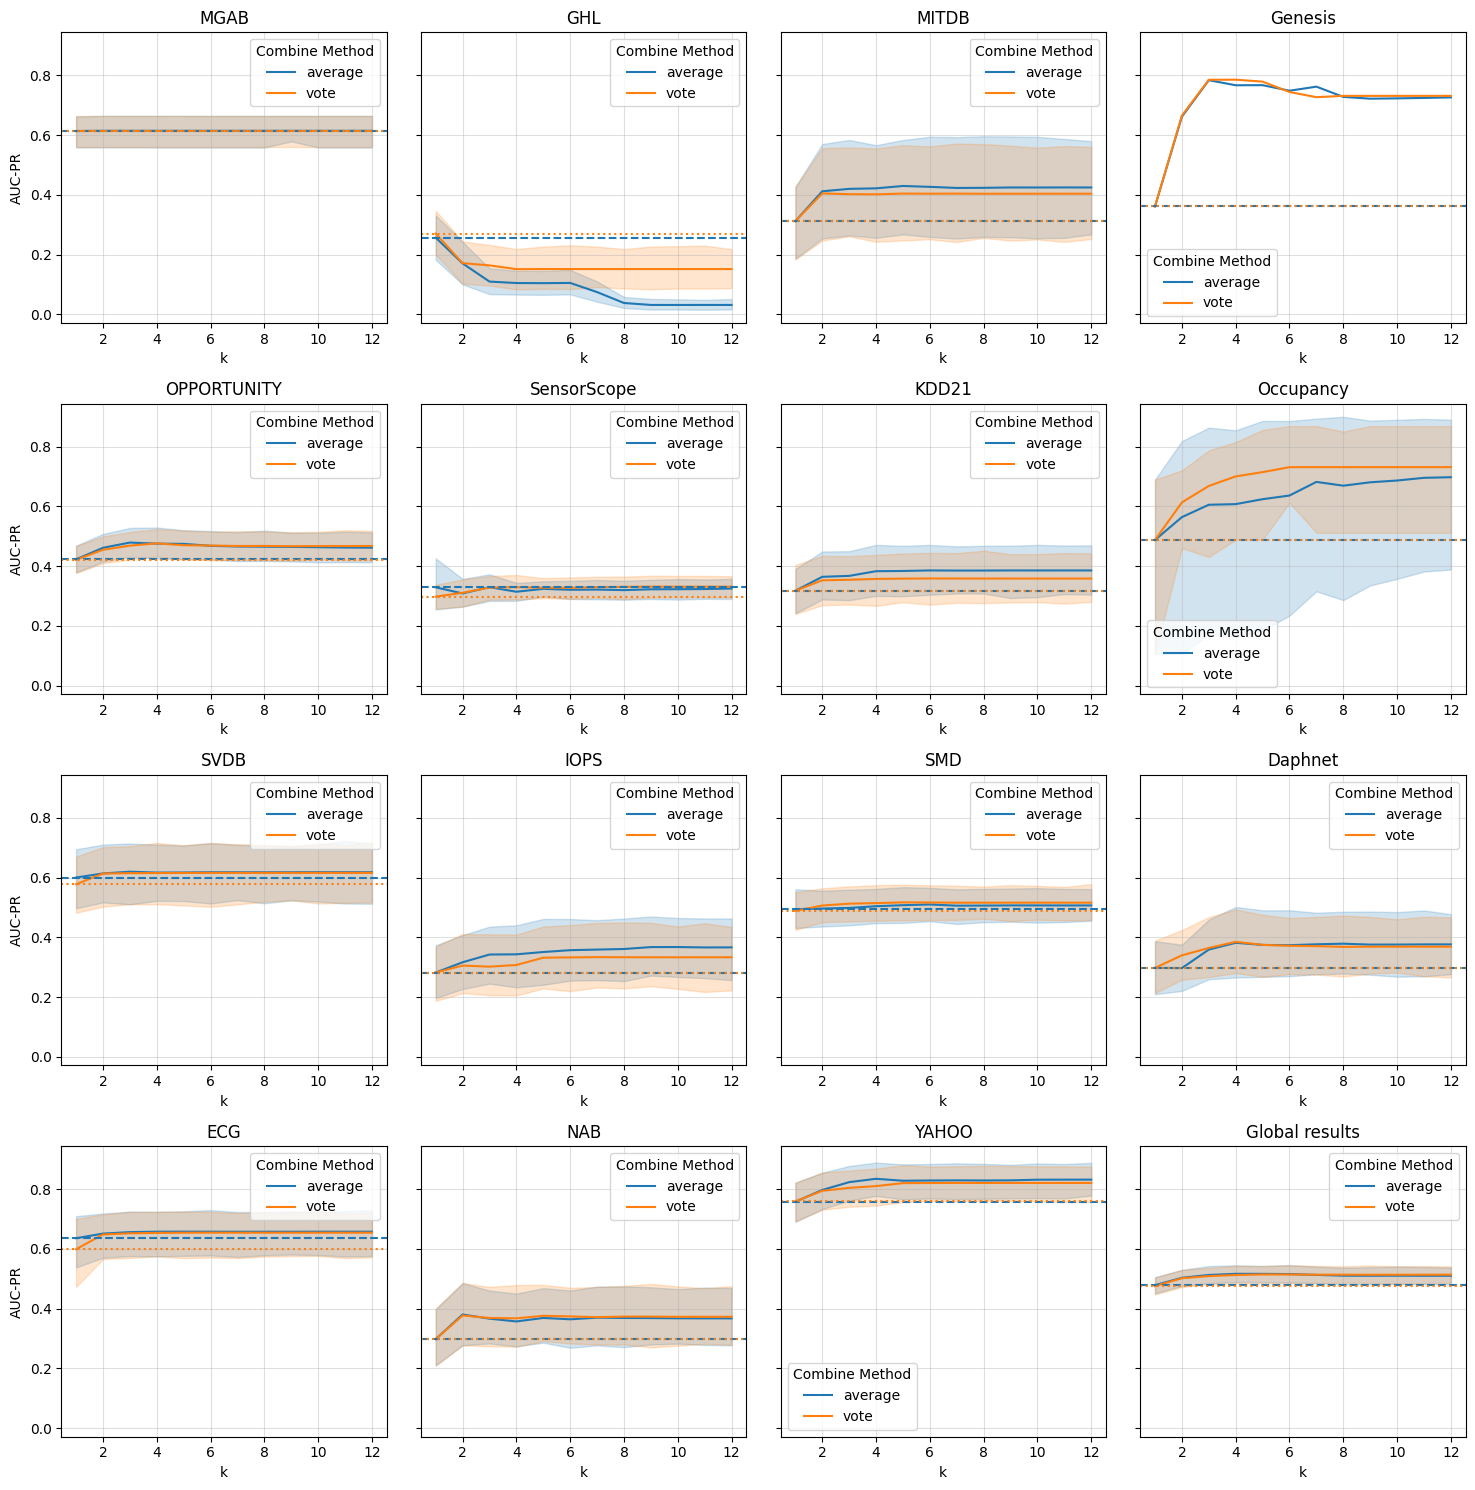

In [10]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)
model_selector = [x for x in model_selectors if 'conv' in x][0]

for i in range (0, len(datasets)):
    curr_data = df[(df["Dataset"] == datasets[i]) & (df["Model Selector"] == model_selector)]

    # Compute average for k = 1
    avg_k_1_average = curr_data[(curr_data["Combine Method"] == 'average') & (curr_data["k"] == 1)]['AUC-PR'].mean()
    avg_k_1_vote = curr_data[(curr_data["Combine Method"] == 'vote') & (curr_data["k"] == 1)]['AUC-PR'].mean()
    
    sns.lineplot(ax=axes[i//4, i % 4], data=curr_data, x="k", y="AUC-PR", hue="Combine Method", hue_order=combine_methods)
    axes[i//4, i % 4].axhline(y=avg_k_1_average, color='C0', linestyle='dashed', label='average k=1')
    axes[i//4, i % 4].axhline(y=avg_k_1_vote, color='C1', linestyle='dotted', label='vote k=1')
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])

# Compute global plot
curr_data = df[(df["Model Selector"] == model_selector)]

# Compute average for k = 1
avg_k_1_average = curr_data[(curr_data["Combine Method"] == 'average') & (curr_data["k"] == 1)]['AUC-PR'].mean()
avg_k_1_vote = curr_data[(curr_data["Combine Method"] == 'vote') & (curr_data["k"] == 1)]['AUC-PR'].mean()

sns.lineplot(ax=axes[3, 3], data=curr_data, x="k", y="AUC-PR", hue="Combine Method", hue_order=combine_methods)
axes[3, 3].axhline(y=avg_k_1_average, color='C0', linestyle='dashed', label='average k=1')
axes[3, 3].axhline(y=avg_k_1_vote, color='C1', linestyle='dotted', label='vote k=1')
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")

plt.tight_layout()
plt.show()

### Evaluating the increase (or decrease) in accuracy

#### Globaly

In [14]:
# Create an empty DataFrame to store the results
global_results = {
    'Model Selector': [], 
    'Combine Method': [],
    'k': [], 
    'Metric': [],
    'Value': [],
}

# Iterate over each combination of model selector and combine method
for model_selector in model_selectors:
    for combine_method in combine_methods:
        tmp_df = df[(df["Model Selector"] == model_selector) & (df["Combine Method"] == combine_method)]
        curr_k1_avg = tmp_df[tmp_df['k'] == 1]['AUC-PR'].mean()
        
        # Compute the percentage change for each value of k
        for k in k_values:
            curr_k_avg = tmp_df[tmp_df['k'] == k]['AUC-PR'].mean()
            percentage_change = ((curr_k_avg - curr_k1_avg) / curr_k1_avg) * 100

            # Append the result to the DataFrame
            global_results['Model Selector'].append(model_selector)
            global_results['Combine Method'].append(combine_method)
            global_results['k'].append(k)
            # global_results['AUC-PR'].append((np.round(curr_k_avg, 2), np.round(percentage_change, 2)))
            global_results['Metric'].append('AUC-PR')
            global_results['Value'].append(curr_k_avg)

            global_results['Model Selector'].append(model_selector)
            global_results['Combine Method'].append(combine_method)
            global_results['k'].append(k)
            global_results['Metric'].append('Percentage change')
            global_results['Value'].append(percentage_change)
                       
global_results_df = pd.DataFrame.from_dict(global_results)

# Print the results DataFrame
global_results_df = global_results_df.pivot(index=["Model Selector", "Combine Method", "Metric"], columns="k", values="Value")
global_results_df.index
s = global_results_df.style.apply(highlight_max, axis=1).format({"AUC-PR": '{:.2f}', "Percentage change": '{:.1f}'}, na_rep='MISS', precision=2)
s
# print(s.to_latex())

#### Per dataset

In [17]:
spec_dataset = [x for x in datasets if 'occ'.lower() in x.lower()]
spec_dataset

['Occupancy']

In [19]:
# Create an empty DataFrame to store the results
global_results = {
    'Dataset': [],
    'Model Selector': [], 
    'Combine Method': [],
    'k': [], 
    'AUC-PR': []
}

# Iterate over each combination of model selector and combine method
for dataset in datasets:
    for model_selector in model_selectors:
        for combine_method in combine_methods:
            tmp_df = df[(df["Dataset"] == dataset) & (df["Model Selector"] == model_selector) & (df["Combine Method"] == combine_method)]
            curr_k1_avg = tmp_df[tmp_df['k'] == 1]['AUC-PR'].mean()
            
            # Compute the percentage change for each value of k
            for k in k_values:
                curr_k_avg = tmp_df[tmp_df['k'] == k]['AUC-PR'].mean()
                percentage_change = ((curr_k_avg - curr_k1_avg) / curr_k1_avg) * 100
    
                # Append the result to the DataFrame
                global_results['Dataset'].append(dataset)
                global_results['Model Selector'].append(model_selector)
                global_results['Combine Method'].append(combine_method)
                global_results['k'].append(k)
                global_results['AUC-PR'].append((np.round(curr_k_avg, 2), np.round(percentage_change, 2)))
                        
global_results_df = pd.DataFrame.from_dict(global_results)

# Print the results DataFrame
global_results_df = global_results_df.pivot(index=["Dataset", "Model Selector", "Combine Method"], columns="k", values="AUC-PR")
global_results_df.style.apply(highlight_max, axis=1)

### k - Probability Plot

In [28]:
# For this experiment we only need the full predicted probabilities
thresh_df = df[df['k'] == max(k_values)]

# Keep predicted weights of all entries to np array
weight_cols = thresh_df.filter(like="weight")
weight_array = np.array(weight_cols)

# Create dictionary to store data
num_entries = len(thresh_df)
prob_k_plot_data = {
    'k': np.repeat(k_values, num_entries),
    'Probability': np.zeros((len(k_values * num_entries))),
    'Dataset': np.tile(thresh_df['Dataset'].to_numpy(), len(k_values)),
    'AUC-PR': np.tile(thresh_df['AUC-PR'].to_numpy(), len(k_values)),
    'Model Selector': np.tile(thresh_df['Model Selector'].to_numpy(), len(k_values)),
    'Combine Method': np.tile(thresh_df['Combine Method'].to_numpy(), len(k_values)),
}

# Compute cummulative probabilities per sample, per k
for k in tqdm(k_values, desc=f"Computing {k}"):
    for i, weight in enumerate(weight_array):
        curr_sorted_weights = np.sort(weight)[-k:]
        prob_k_plot_data['Probability'][(k-1)*num_entries + i] = curr_sorted_weights.sum()

# Convert dict to DataFrame
prob_k_data_df = pd.DataFrame.from_dict(prob_k_plot_data)
prob_k_data_df['MS - Com. Method'] = prob_k_data_df['Model Selector'] + " - " + prob_k_data_df['Combine Method']
prob_k_data_df

Computing 12: 100%|█████████████████████████████| 12/12 [00:00<00:00, 62.20it/s]


,k,Probability,Dataset,AUC-PR,Model Selector,Combine Method,MS - Com. Method
0,1,0.506912,IOPS,0.613139,sit512,vote,sit512 - vote
1,1,0.284247,IOPS,0.147077,sit512,vote,sit512 - vote
2,1,0.444444,IOPS,0.651186,sit512,vote,sit512 - vote
3,1,0.841270,IOPS,0.116012,sit512,vote,sit512 - vote
4,1,0.660959,IOPS,0.329755,sit512,vote,sit512 - vote
...,...,...,...,...,...,...,...
53515,12,1.000000,OPPORTUNITY,0.698977,knn1024,vote,knn1024 - vote
53516,12,1.000000,OPPORTUNITY,0.767859,knn1024,vote,knn1024 - vote
53517,12,1.000000,OPPORTUNITY,0.952718,knn1024,vote,knn1024 - vote
53518,12,1.000000,OPPORTUNITY,0.441456,knn1024,vote,knn1024 - vote


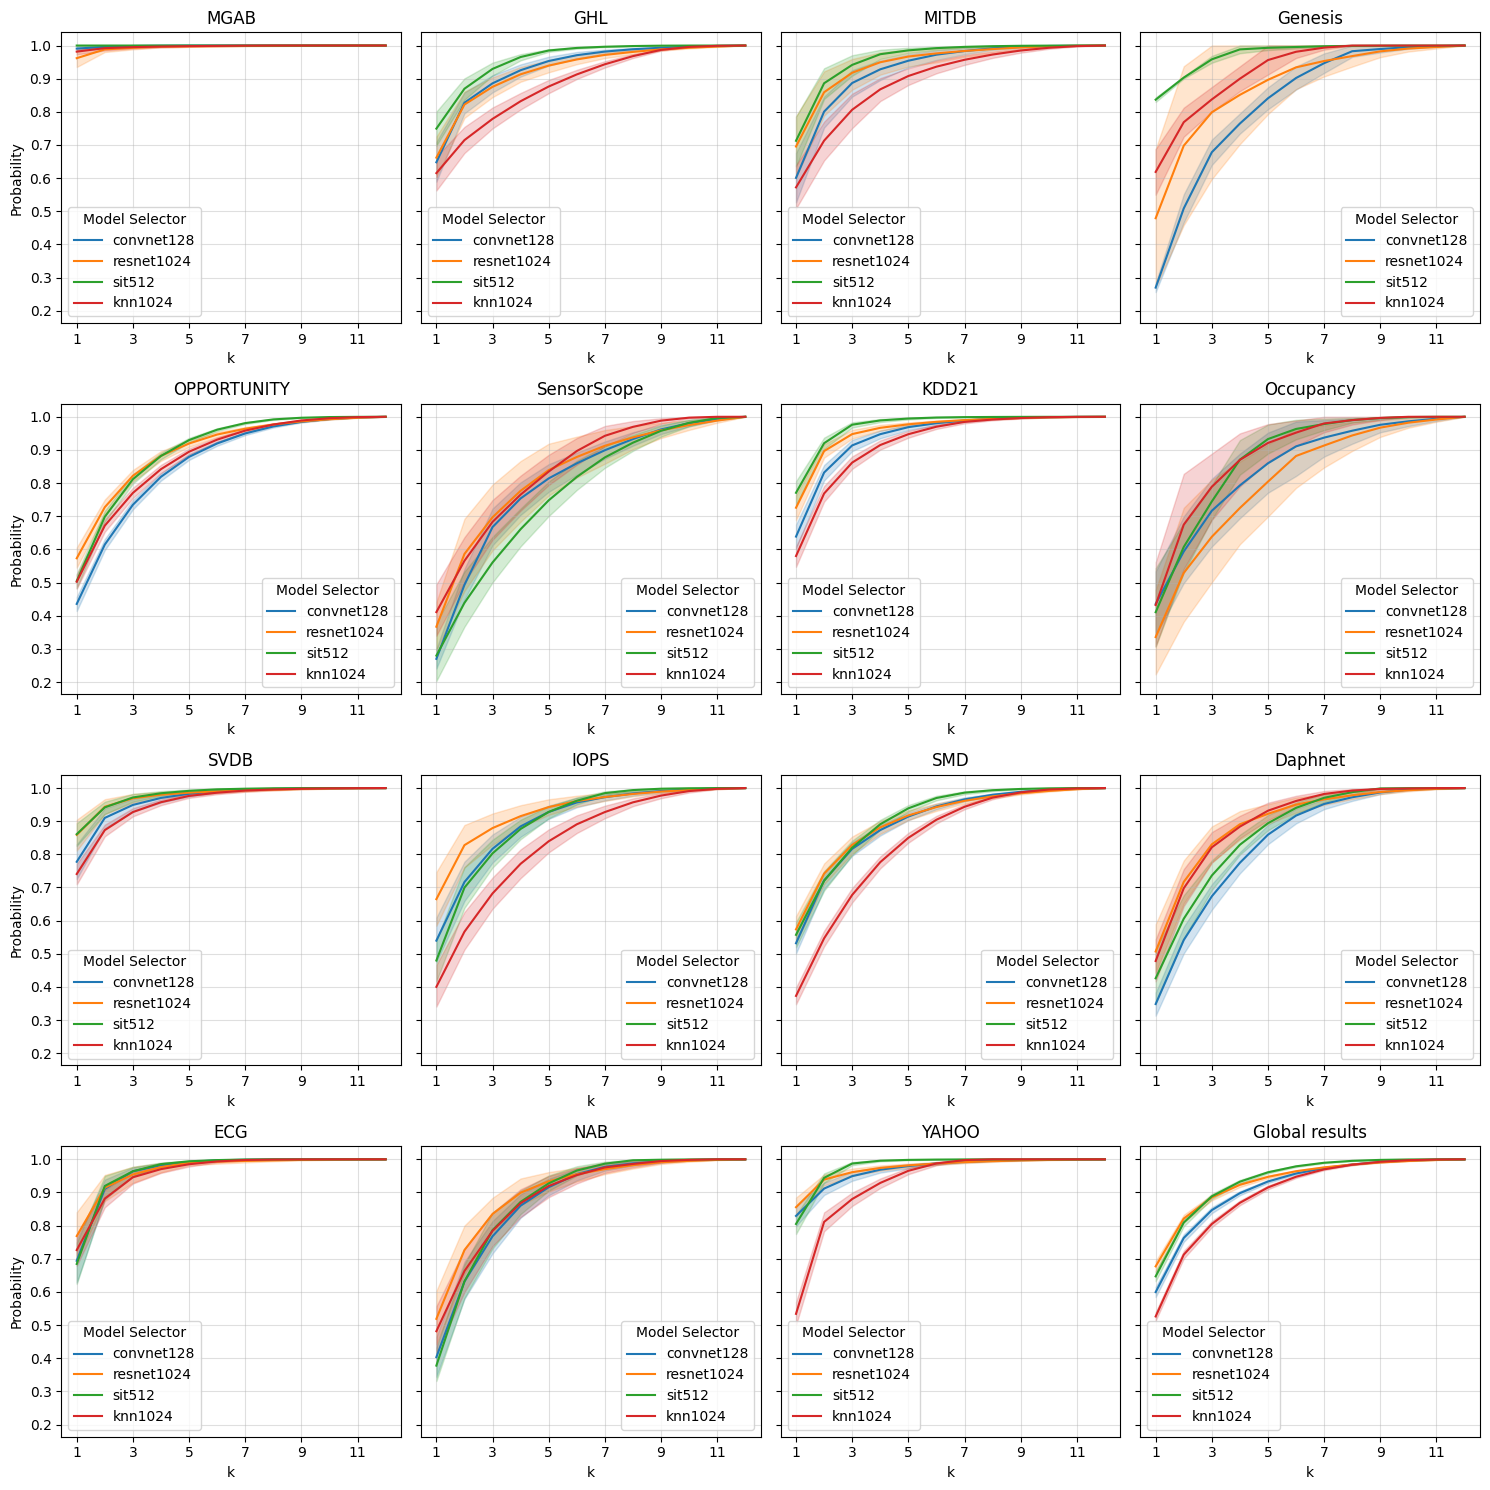

In [35]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)

for i, dataset in enumerate(datasets):
    sns.lineplot(ax=axes[i//4, i % 4], data=prob_k_data_df[prob_k_data_df["Dataset"] == dataset], x='k', y='Probability', hue='Model Selector', hue_order=model_selectors)
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])
    axes[i//4, i % 4].set_xticks(range(min(k_values), max(k_values), 2))
    # axes[i//4, i % 4].get_legend().set_visible(False)

sns.lineplot(ax=axes[3, 3], data=prob_k_data_df, x='k', y='Probability', hue='Model Selector', hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")
axes[3, 3].set_xticks(range(min(k_values), max(k_values), 2))
# axes[3, 3].get_legend().set_visible(False)

plt.tight_layout()
plt.show()

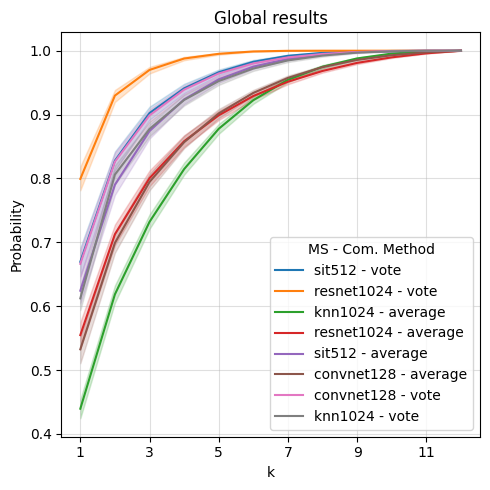

In [31]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(5, 5))
# hue_order = sorted(list(prob_k_data_df['MS - Com. Method'].unique()))

sns.lineplot(ax=ax, data=prob_k_data_df, x='k', y='Probability', hue='MS - Com. Method')
ax.grid(alpha=0.4)
ax.title.set_text("Global results")
ax.set_xticks(range(min(k_values), max(k_values), 2))

plt.tight_layout()
plt.show()

### Cummulative Probability - AUC-PR Plot

In [81]:
# Filter the DataFrame for maximum 'k'
thresh_df = df[df['k'] == max(k_values)]

# Pre-compute and store weights for all combinations of 'Time series', 'Model Selector', 'Combine Method'
grouped_weights = thresh_df.groupby(['Time series', 'Model Selector', 'Combine Method'])
sorted_weights = grouped_weights.apply(lambda x: np.sort(x.filter(like="weight").values.flatten())[::-1])

# Initialize the dictionary for storing results
n_entries = len(df)
prob_auc_dict = {
    'k': np.array(df['k']),
    'Probability': np.zeros(n_entries),
    'Dataset': np.array(df['Dataset']),
    'AUC-PR': np.array(df['AUC-PR']),
    'Model Selector': np.array(df['Model Selector']),
    'Combine Method': np.array(df['Combine Method']),
}

# Compute cumulative probabilities per sample, per k
for i, elem in tqdm(enumerate(df.iterrows()), desc="Computing Prob - AUC plot", total=len(df)):
    index, row = elem
    
    key = (row['Time series'], row['Model Selector'], row['Combine Method'])
    if key in sorted_weights:
        curr_weights = sorted_weights[key]
        curr_cumm_weights = curr_weights[:row['k']]
        # print(index)
        # break
        
        prob_auc_dict['Probability'][i] = curr_cumm_weights.sum()

prob_auc_df = pd.DataFrame.from_dict(prob_auc_dict)
prob_auc_df

Computing Prob - AUC plot: 100%|███████| 53520/53520 [00:04<00:00, 12345.09it/s]


,k,Probability,Dataset,AUC-PR,Model Selector,Combine Method
0,4,0.843318,OPPORTUNITY,0.627780,convnet128,vote
1,4,0.911392,OPPORTUNITY,0.440608,convnet128,vote
2,4,0.845238,OPPORTUNITY,0.910242,convnet128,vote
3,4,0.889552,OPPORTUNITY,0.379734,convnet128,vote
4,4,0.895833,OPPORTUNITY,0.088045,convnet128,vote
...,...,...,...,...,...,...
53515,9,1.000000,GHL,0.006826,convnet128,vote
53516,9,1.000000,GHL,0.009475,convnet128,vote
53517,9,1.000000,GHL,0.000760,convnet128,vote
53518,9,1.000000,GHL,0.062132,convnet128,vote


In [82]:
# Define the conditions
conditions = [
    prob_auc_df['Probability'] <= 0.2,  # Up to 0.2
    (prob_auc_df['Probability'] > 0.2) & (prob_auc_df['Probability'] <= 0.4),  # Greater than 0.2 up to 0.4
    (prob_auc_df['Probability'] > 0.4) & (prob_auc_df['Probability'] <= 0.6),  # Greater than 0.4 up to 0.6
    (prob_auc_df['Probability'] > 0.6) & (prob_auc_df['Probability'] <= 0.8),  # Greater than 0.6 up to 0.8
    prob_auc_df['Probability'] > 0.8  # Greater than 0.8
]

# Define the choices, matching the conditions
choices = [
    '0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0'
]

# Apply np.select to create a new column with the categorized data
prob_auc_df['Probability Group'] = np.select(conditions, choices, default='Unknown')

# Show the DataFrame to verify
prob_auc_df

,k,Probability,Dataset,AUC-PR,Model Selector,Combine Method,Probability Group
0,4,0.843318,OPPORTUNITY,0.627780,convnet128,vote,0.8 - 1.0
1,4,0.911392,OPPORTUNITY,0.440608,convnet128,vote,0.8 - 1.0
2,4,0.845238,OPPORTUNITY,0.910242,convnet128,vote,0.8 - 1.0
3,4,0.889552,OPPORTUNITY,0.379734,convnet128,vote,0.8 - 1.0
4,4,0.895833,OPPORTUNITY,0.088045,convnet128,vote,0.8 - 1.0
...,...,...,...,...,...,...,...
53515,9,1.000000,GHL,0.006826,convnet128,vote,0.8 - 1.0
53516,9,1.000000,GHL,0.009475,convnet128,vote,0.8 - 1.0
53517,9,1.000000,GHL,0.000760,convnet128,vote,0.8 - 1.0
53518,9,1.000000,GHL,0.062132,convnet128,vote,0.8 - 1.0


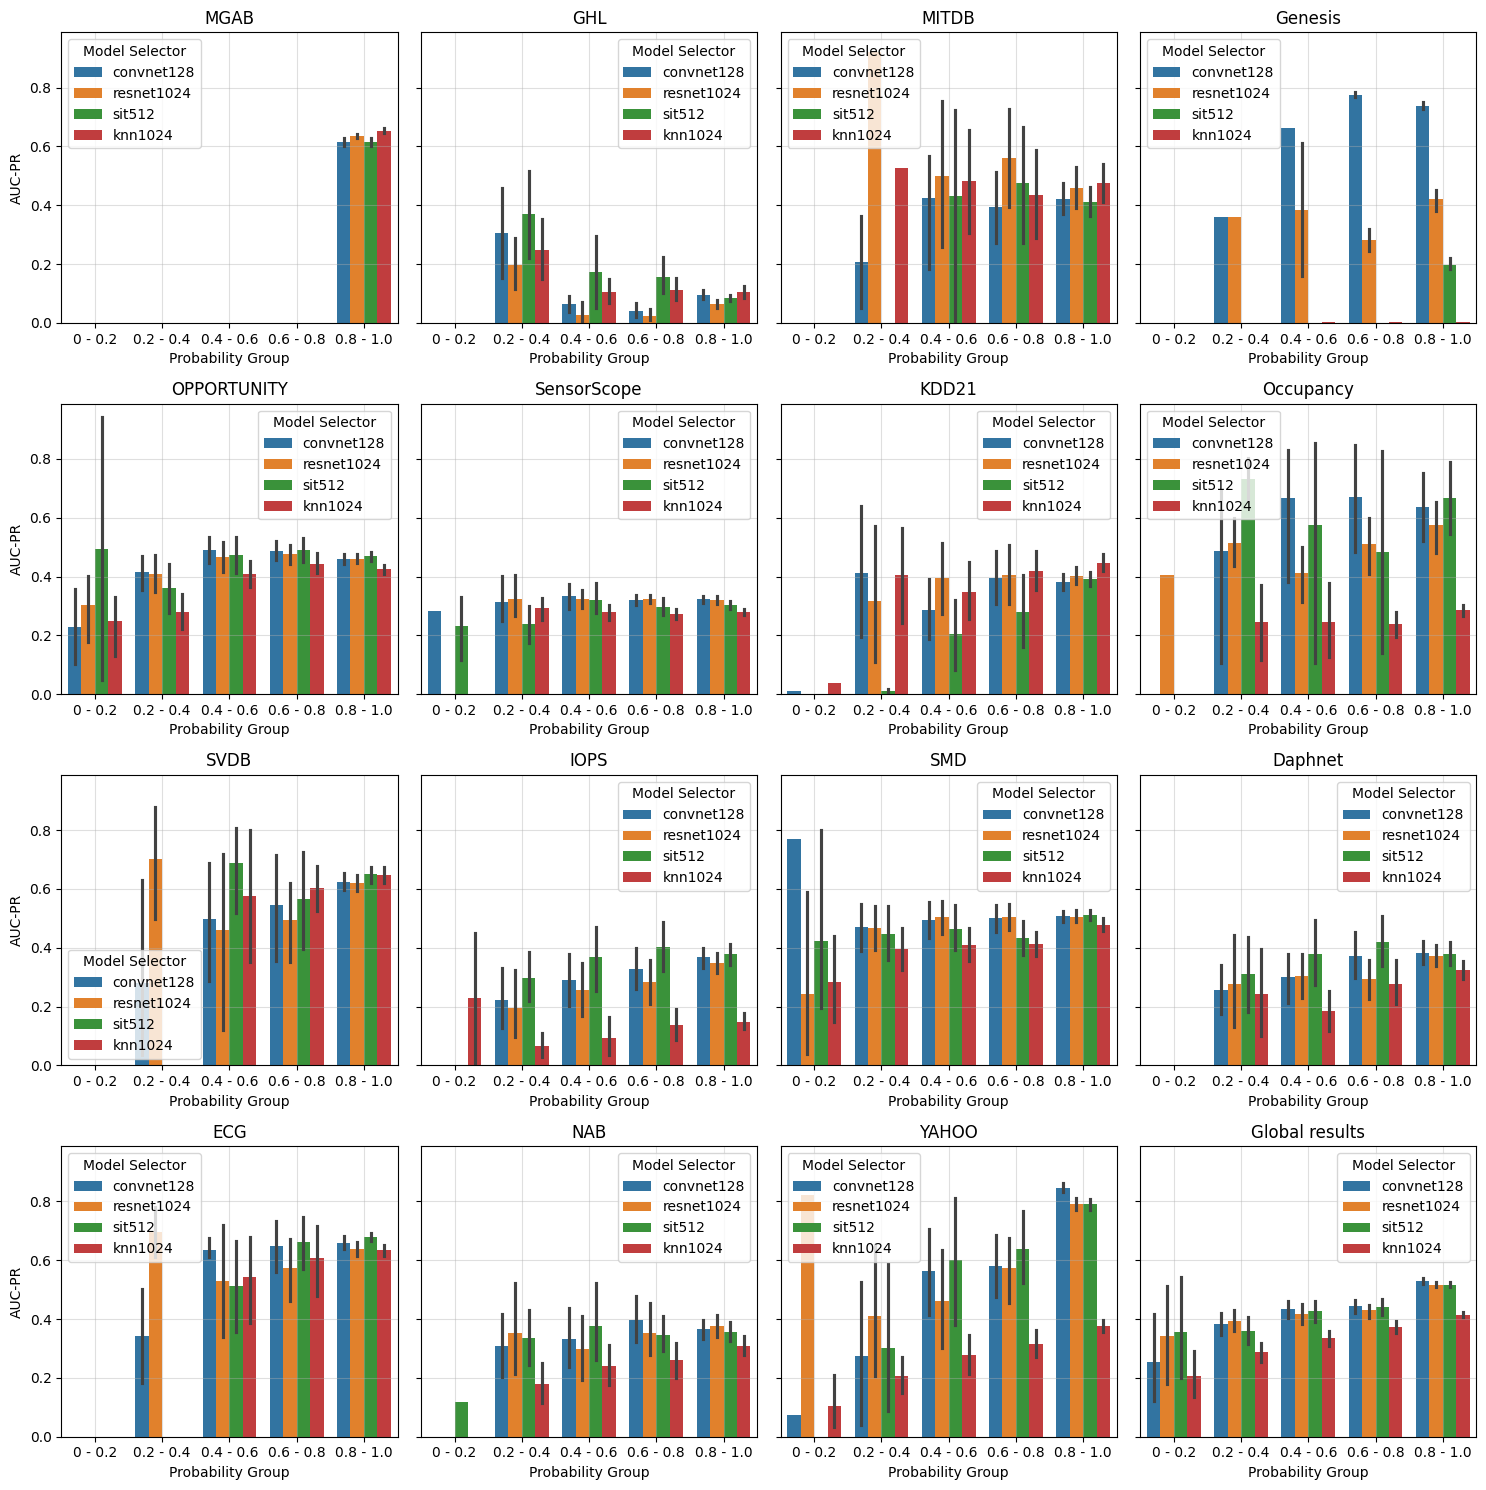

In [86]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)
tmp_prob_auc_df = prob_auc_df[prob_auc_df['Combine Method'] == 'average']

for i, dataset in enumerate(datasets):
    sns.barplot(ax=axes[i//4, i % 4], data=tmp_prob_auc_df[tmp_prob_auc_df["Dataset"] == dataset], x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])

sns.barplot(ax=axes[3, 3], data=tmp_prob_auc_df, x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")

plt.tight_layout()
plt.show()

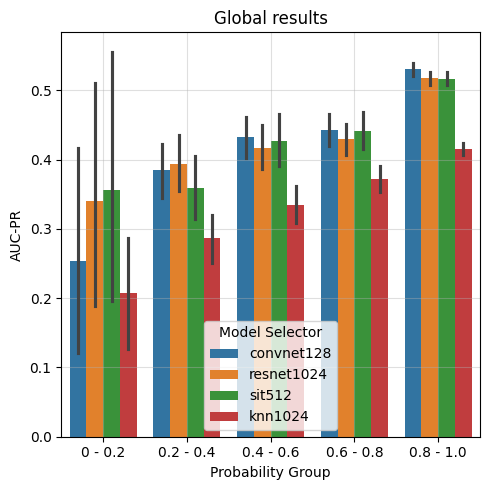

In [87]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(ax=ax, data=tmp_prob_auc_df, x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
ax.grid(alpha=0.4)
ax.title.set_text("Global results")

plt.tight_layout()
plt.show()

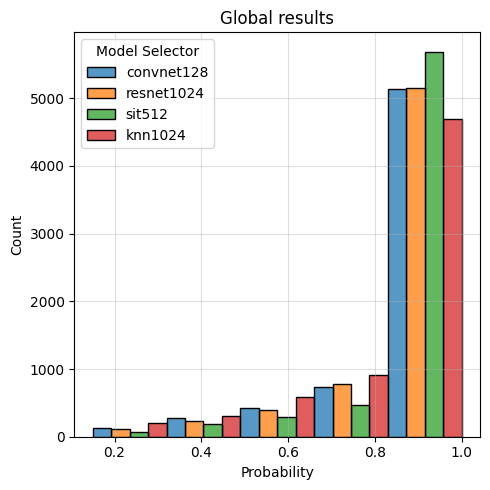

In [88]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(5, 5))

sns.histplot(ax=ax, data=tmp_prob_auc_df, x='Probability', hue='Model Selector', multiple="dodge", bins=len(choices), hue_order=model_selectors)
ax.grid(alpha=0.4)
ax.title.set_text("Global results")

plt.tight_layout()
plt.show()